In [1]:
import tensorflow as tf
import math
import os
from six.moves import xrange
import numpy as np
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 10 #digits 0 to 9
IMAGE_SIZE = 28 #28 * 28 pixels per image
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
BATCH_SIZE = 100
EVAL_BATCH_SIZE = 1

HIDDEN1_UNITS = 128
HIDDEN2_UNITS = 32

MAX_STEPS = 5000

TRAIN_DIR = "/tmp/mnist"

In [3]:
data_sets = read_data_sets(TRAIN_DIR, False)

Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
def mnist_inference(images, hidden1_units, hidden2_units): #inference graph
    with tf.name_scope('hidden1'): #hidden layer 1
        with tf.name_scope('weights'):
            weights = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden1_units], stddev=1.0/math.sqrt(float(IMAGE_PIXELS))),name='weights')
            tf.histogram_summary('hidden1' + '/weights', weights)
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.zeros([hidden1_units]),name='biases')
            tf.histogram_summary('hidden1' + '/biases', biases)
        with tf.name_scope('Wx_plus_b'):
            pre_activation=tf.matmul(images, weights) + biases
        hidden1 = tf.nn.relu(pre_activation)
        tf.histogram_summary('hidden1' + '/outputs', hidden1)
    with tf.name_scope('hidden2'): #hidden layer 2
        with tf.name_scope('weights'):
            weights = tf.Variable(tf.truncated_normal([hidden1_units, hidden2_units],stddev=1.0 / math.sqrt(float(hidden1_units))),name='weights')
            tf.histogram_summary('hidden2' + '/weights', weights)
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.zeros([hidden2_units]),name='biases')
            tf.histogram_summary('hidden2' + '/biases', biases)
        with tf.name_scope('Wx_plus_b'):
            pre_activation=tf.matmul(hidden1, weights) + biases
        hidden2 = tf.nn.relu(pre_activation)
        tf.histogram_summary('hidden2' + '/outputs', hidden2)
    with tf.name_scope('softmax_linear'): #softmax activation for output layer
        with tf.name_scope('weights'):
            weights = tf.Variable(tf.truncated_normal([hidden2_units, NUM_CLASSES],stddev=1.0 / math.sqrt(float(hidden2_units))),name='weights')
            tf.histogram_summary('softmax_linear' + '/weights', weights)
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.zeros([NUM_CLASSES]),name='biases')
            tf.histogram_summary('softmax_linear' + '/biases', biases)
        with tf.name_scope('Wx_plus_b'):
            logits = tf.matmul(hidden2, weights) + biases
        tf.histogram_summary('softmax_linear' + '/outputs', logits)
    tf.train.write_graph(tf.get_default_graph().as_graph_def(),"/tmp","inference.pbtxt", as_text=True)
    return logits

In [5]:
def mnist_training(logits, labels, learning_rate): #training graph
    labels = tf.to_int64(labels)
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels, name='xentropy')
        loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
        tf.scalar_summary('loss', loss)
    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        global_step = tf.Variable(0, name='global_step', trainable=False) #checkpoints
        train_op = optimizer.minimize(loss, global_step=global_step)
    tf.train.write_graph(tf.get_default_graph().as_graph_def(),"/tmp", "train.pbtxt", as_text=True)
    return train_op, loss

In [6]:
mnist_graph = tf.Graph()
with mnist_graph.as_default():
    with tf.name_scope('inputs'):
        images_placeholder = tf.placeholder(tf.float32)                                       
        labels_placeholder = tf.placeholder(tf.int32)
    tf.add_to_collection("images", images_placeholder)
    tf.add_to_collection("labels", labels_placeholder)
    logits = mnist_inference(images_placeholder,HIDDEN1_UNITS,HIDDEN2_UNITS)
    tf.add_to_collection("logits", logits)
    train_op, loss = mnist_training(logits, labels_placeholder, 0.01)
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()
    tf.train.write_graph(tf.get_default_graph().as_graph_def(),"/tmp", "complete.pbtxt", as_text=True)
    

Step 0: loss = 2.31
Step 100: loss = 2.13
Step 200: loss = 1.87
Step 300: loss = 1.52
Step 400: loss = 1.32
Step 500: loss = 0.85
Step 600: loss = 0.74
Step 700: loss = 0.67
Step 800: loss = 0.48
Step 900: loss = 0.60
Step 1000: loss = 0.52
Step 1100: loss = 0.39
Step 1200: loss = 0.50
Step 1300: loss = 0.37
Step 1400: loss = 0.37
Step 1500: loss = 0.49
Step 1600: loss = 0.46
Step 1700: loss = 0.46
Step 1800: loss = 0.29
Step 1900: loss = 0.41
Step 2000: loss = 0.46
Step 2100: loss = 0.38
Step 2200: loss = 0.43
Step 2300: loss = 0.68
Step 2400: loss = 0.28
Step 2500: loss = 0.35
Step 2600: loss = 0.25
Step 2700: loss = 0.26
Step 2800: loss = 0.18
Step 2900: loss = 0.33
Step 3000: loss = 0.12
Step 3100: loss = 0.30
Step 3200: loss = 0.19
Step 3300: loss = 0.33
Step 3400: loss = 0.20
Step 3500: loss = 0.23
Step 3600: loss = 0.33
Step 3700: loss = 0.29
Step 3800: loss = 0.16
Step 3900: loss = 0.28
Step 4000: loss = 0.50
Step 4100: loss = 0.32
Step 4200: loss = 0.28
Step 4300: loss = 0.18


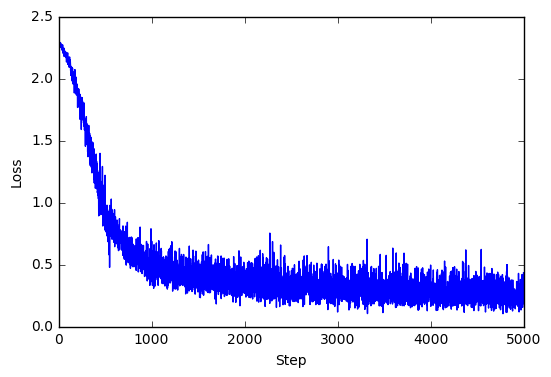

In [7]:
loss_lst = list()
with tf.Session(graph=mnist_graph) as sess:
    merged = tf.merge_all_summaries()
    writer = tf.train.SummaryWriter('logs/', sess.graph)
    sess.run(init)
    for step in xrange(MAX_STEPS):
        images_feed, labels_feed = data_sets.train.next_batch(BATCH_SIZE)
        _, loss_value = sess.run([train_op, loss],feed_dict={images_placeholder: images_feed,labels_placeholder: labels_feed})
        loss_lst.append(loss_value)
        if step % 100 == 0:
            print('Step %d: loss = %.2f' % (step, loss_value))
            result = sess.run(merged,feed_dict={images_placeholder: images_feed,labels_placeholder: labels_feed})
            writer.add_summary(result, step)
            
    plt.plot(loss_lst)
    plt.xlabel('Step', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)

Ground truth: 5
Prediction: 5


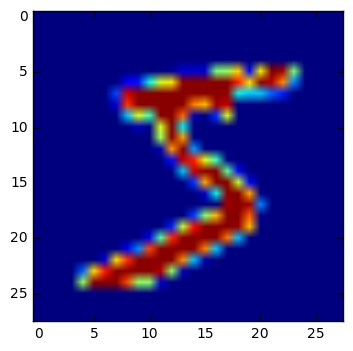

In [8]:
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(os.path.join(TRAIN_DIR, "checkpoint-4999.meta")) #error here. re-ckeck for checkpoints
    saver.restore(sess, os.path.join(TRAIN_DIR, "checkpoint-4999"))

    logits = tf.get_collection("logits")[0]
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    eval_op = tf.nn.top_k(logits)
    
    images_feed, labels_feed = data_sets.validation.next_batch(EVAL_BATCH_SIZE)
    imgplot = plt.imshow(np.reshape(images_feed, (28, 28)))
    prediction = sess.run(eval_op,feed_dict={images_placeholder: images_feed,labels_placeholder: labels_feed})
    print("Ground truth: %d\nPrediction: %d" % (labels_feed, prediction.indices[0][0]))